In [1]:
!pip install torch 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 168.0 MB/s eta 0:00:01^C:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 168.0 MB/s eta 0:00:01

**Module 1**

In [2]:
import torch 
import torch.nn as nn 
import torchvision 
import torch.nn.functional as F
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader 
import torch.optim as optim
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

**Data PipeLine (CIFAR10)**

In [3]:
transform = transforms.Compose([ 
    transforms.Resize((224,224)), #Resnet expects this shape 
    transforms.ToTensor(), 
    transforms.Normalize(0.5,0.5) #ensure values are in range [-1,1] 
]) 

train_dataset = torchvision.datasets.CIFAR10( 
    root ="./data", train = True, download = True, transform = transform) 

test_dataset = torchvision.datasets.CIFAR10( 
    root="./data", train = False, download = True, transform = transform) 

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True) 
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True) 


100%|██████████| 170M/170M [00:05<00:00, 31.5MB/s] 


In [4]:
from torchvision.models import resnet18 

model = resnet18(pretrained = True)

#modify the final layer so it can predict 10 classes 
model.fc = nn.Linear(model.fc.in_features, 10) 

device = torch.device("cuda" if torch.cuda.is_available else "cpu") 
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


**Training Script**

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training function
def train_model(model, loader, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            # Move inputs and labels to device
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # If model returns tuple, use outputs[0]
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")

# 5. Call training
train_model(model, train_loader, epochs=10)

KeyboardInterrupt: 

In [6]:
torch.save(model.state_dict(), "resnet_cifar10.pth")


**Loading model**

In [5]:

model.load_state_dict(torch.load("/kaggle/input/resnet/resnet_cifar10.pth"))

<All keys matched successfully>

In [6]:
for name, module in model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


**Registering Hooks to capture Activations and Gradients**

In [7]:
activations = {}
gradients = {}

def get_activation(name):
    def forward_hook(model, input, output):
        activations[name] = output.detach()
    return forward_hook

def get_gradient(name):
    def backward_hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0].detach()
    return backward_hook

**Attach hooks to a few layers**

In [8]:
# Early Layer: Low-level edges/textures
model.conv1.register_forward_hook(get_activation("conv1"))

# Early Residual Block: First layer of layer1
model.layer1[0].conv1.register_forward_hook(get_activation("layer1.0.conv1"))

# Mid-level Layer: Good balance of abstraction and structure
model.layer2[0].conv1.register_forward_hook(get_activation("layer2.0.conv1"))

# Deeper Layer: Starting to capture object parts
model.layer3[1].conv2.register_forward_hook(get_activation("layer3.1.conv2"))

# Very Deep Layer: High-level class-specific features
model.layer4[1].conv2.register_forward_hook(get_activation("layer4.1.conv2"))

# Final Layer: Class scores (optional, for logits not spatial features)
model.fc.register_forward_hook(get_activation("fc"))


In [9]:
# Very early layer: capturing raw gradients from shallowest layer
model.conv1.register_full_backward_hook(get_gradient("conv1"))

# Early residual block
model.layer1[0].conv1.register_full_backward_hook(get_gradient("layer1.0.conv1"))

# Mid-level layer
model.layer2[0].conv1.register_full_backward_hook(get_gradient("layer2.0.conv1"))

# Deeper block for more abstract gradients
model.layer3[1].conv2.register_full_backward_hook(get_gradient("layer3.1.conv2"))

# Very deep layer, class-specific gradient influence
model.layer4[1].conv2.register_full_backward_hook(get_gradient("layer4.1.conv2"))

# Fully connected output layer (final logits)
model.fc.register_full_backward_hook(get_gradient("fc"))


In [10]:
model.to(device).eval()
dataiter = iter(test_loader) 
images,labels = next(dataiter) 
images,labels = images.to(device), labels.to(device) 

In [11]:
#Forward Pass
output = model(images)
predicted_class = output[0].argmax()

#Backward Pass 
model.zero_grad()
output[0, predicted_class.item()].backward()

In [12]:
def plot_activation(activation_tensor, layer_name, num_channels=12):
    act = activation_tensor[0][:num_channels]  # Take first sample in batch
    fig, axs = plt.subplots(1, num_channels, figsize=(18, 4))
    for i in range(num_channels):
        axs[i].imshow(act[i].detach().cpu(), cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'{layer_name}\nCh {i}')
    plt.tight_layout()
    plt.show()


### Activation Map Visualization

The plot below shows the **activation maps** (feature maps) of the input image as it passes through selected convolutional layers of a CNN (ResNet variant):

#### Layers Visualized:
- `conv1`
- `layer1.0.conv1`
- `layer2.0.conv1`
- `layer3.1.conv2`
- `layer4.1.conv2`

Each row corresponds to a different layer, and each column represents one output **channel** (feature map) from that layer.

####  Interpretation:
- **Shallow layers** (top rows) capture basic features like **edges**, **colors**, and **textures**.
- **Deeper layers** (bottom rows) highlight more **abstract**, **high-level** patterns and shapes.
- As we go deeper, the spatial resolution reduces, but the feature richness increases.

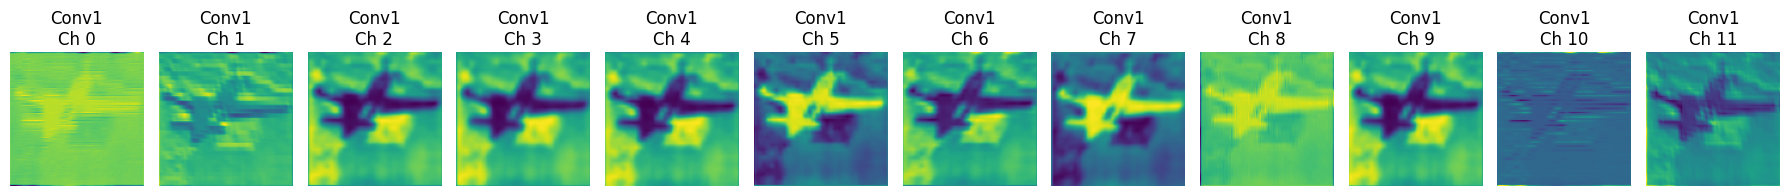

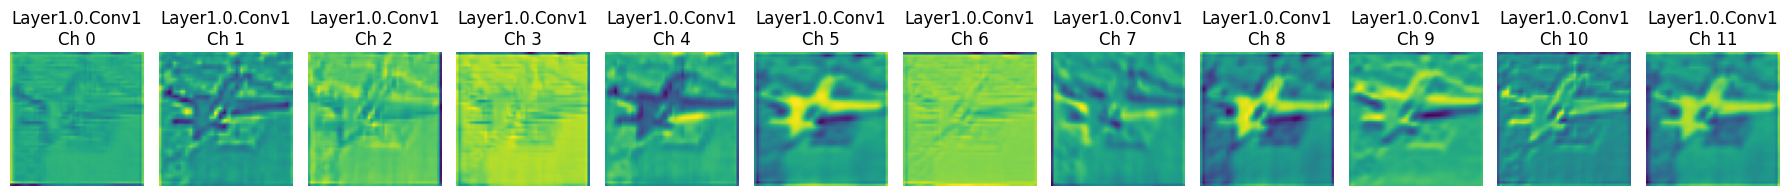

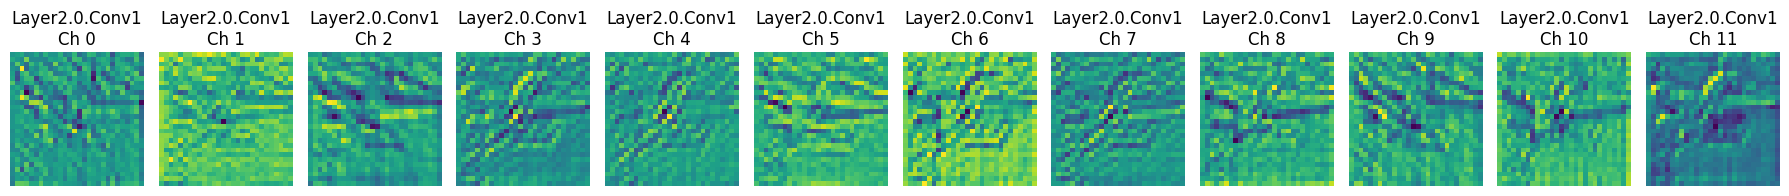

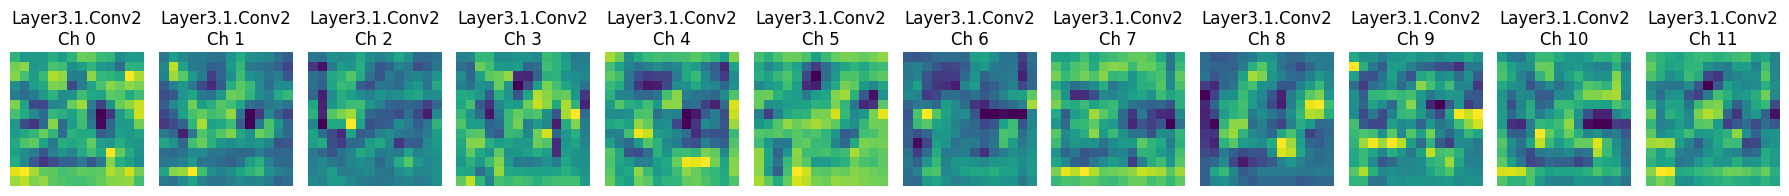

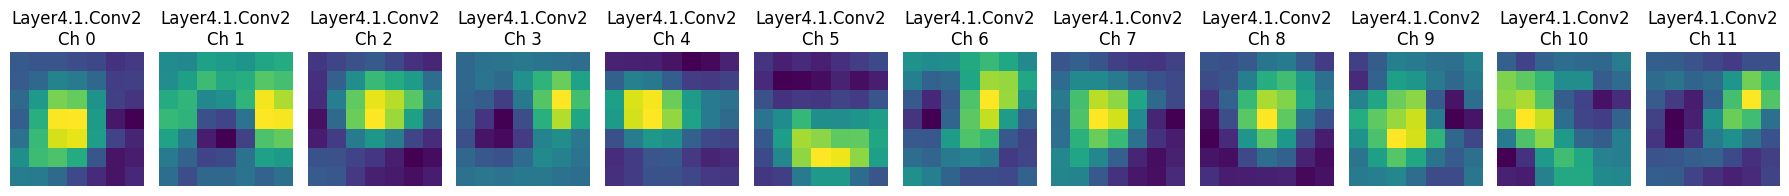

In [13]:
plot_activation(activations['conv1'], 'Conv1')

plot_activation(activations['layer1.0.conv1'], 'Layer1.0.Conv1')

plot_activation(activations['layer2.0.conv1'], 'Layer2.0.Conv1')

plot_activation(activations['layer3.1.conv2'], 'Layer3.1.Conv2')

plot_activation(activations['layer4.1.conv2'], 'Layer4.1.Conv2')

In [14]:
fc_sample = activations['fc'][0]  # Assuming batch dim exists
print("Shape:", fc_sample.shape)
print("Tensor:", fc_sample)


Shape: torch.Size([10])
Tensor: tensor([  4.3133, -10.5238, -11.1718,  -0.7849,  -4.8718,  -4.7425, -10.7768,
         -6.2734,  -3.7116,  -1.0384], device='cuda:0')


**Plots the fully connected layer activations (logits) as a bar chart.
Highlights the predicted class**.

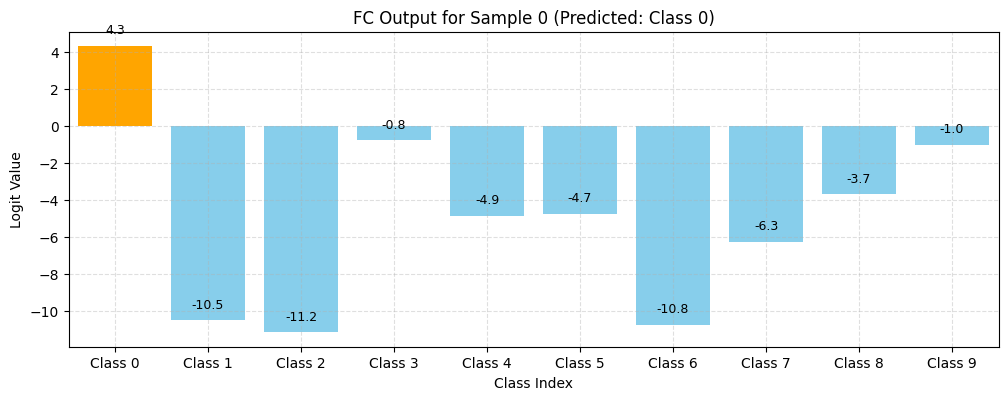

In [15]:

def plot_fc_activation(fc_activation, index=0, class_names=None):

    fc_data = fc_activation[index].detach().cpu().numpy().squeeze()

    x = np.arange(len(fc_data))
    predicted_class = np.argmax(fc_data)
    colors = ['skyblue'] * len(fc_data)
    colors[predicted_class] = 'orange'

    plt.figure(figsize=(12, 5))
    bars = plt.bar(x, fc_data, color=colors)

    # Annotate values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    if class_names and len(class_names) == len(fc_data):
        plt.xticks(x, class_names, rotation=45, ha='right')
    else:
        plt.xticks(x, [f"Class {i}" for i in x], rotation=0)

    plt.title(f"FC Output for Sample {index} (Predicted: Class {predicted_class})")
    plt.xlabel("Class Index")
    plt.ylabel("Logit Value")
    plt.grid(True, linestyle='--', alpha=0.4)
    
    # Fix margins and visibility
    plt.subplots_adjust(bottom=0.25)
    plt.xlim(-0.5, len(fc_data)-0.5)  # Ensure all bars fit in view

    plt.show()

# Call it:
plot_fc_activation(activations['fc'], index=0)


In [16]:
# Convert logits to softmax probabilities
probs = F.softmax(output, dim=1)  

# Confidence scores = max prob per sample
confidences, preds = torch.max(probs, dim=1)  

# Get index of highest and lowest confidence
highest_conf_idx = torch.argmax(confidences).item()
lowest_conf_idx = torch.argmin(confidences).item()

print("Highest confidence sample index:",highest_conf_idx)
print("Lowest confidence sample index:",lowest_conf_idx)


Highest confidence sample index: 1
Lowest confidence sample index: 3


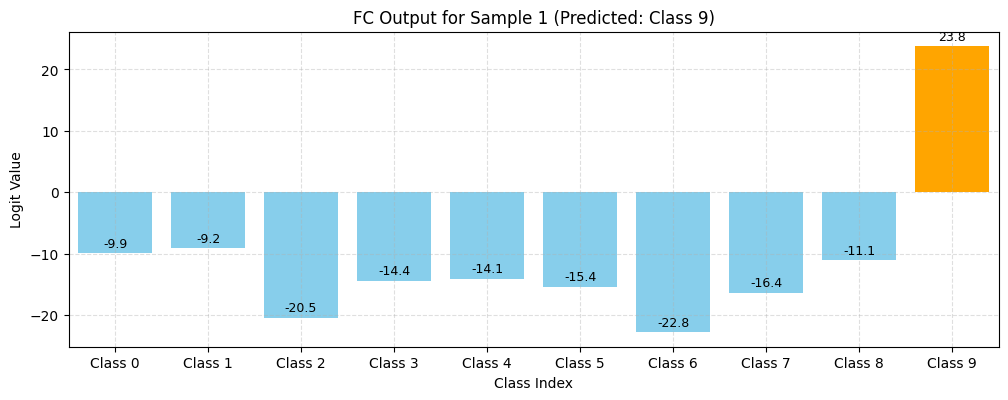

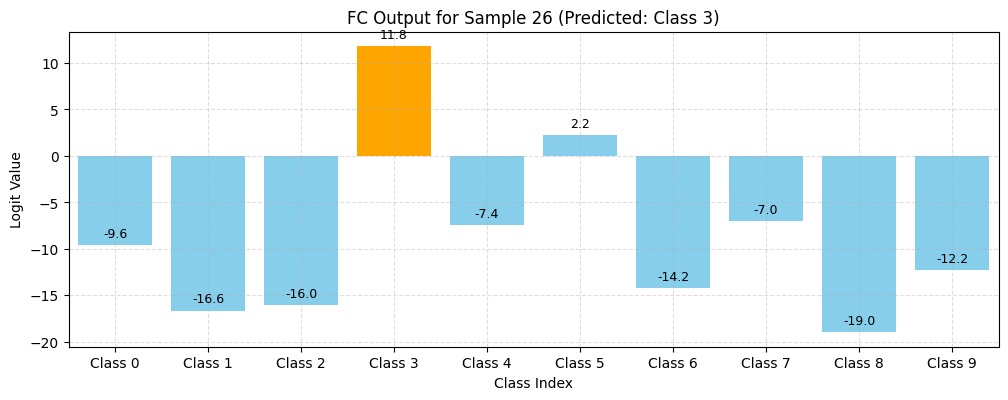

In [17]:
plot_fc_activation(activations['fc'], index = 1)
plot_fc_activation(activations['fc'], index = 26)

In [24]:

import cv2

def compute_gradcam(image, activations, gradients, target_layer_name, index=None):
    # Get the activations and gradients
    act = activations[target_layer_name]       
    grad = gradients[target_layer_name]         

    if index is not None:
        act = act[index]
        grad = grad[index]
    else:
        act = act[0]
        grad = grad[0]

    # Global Average Pooling of gradients over width and height
    pooled_grad = torch.mean(grad, dim=(1, 2))   # [C]

    # Weight the channels by the gradients
    for i in range(act.shape[0]):
        act[i] *= pooled_grad[i]

    # Generate the heatmap
    heatmap = act.sum(dim=0).detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)             # ReLU
    heatmap /= np.max(heatmap) + 1e-8            # Normalize to [0, 1]

    # Resize heatmap to match input image size
    heatmap = cv2.resize(heatmap, (image.shape[3], image.shape[2]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Prepare input image (convert from tensor to numpy)
    img = image[0].permute(1, 2, 0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize to [0,1]
    img = np.uint8(255 * img)

    if img.shape[2] == 1:  # grayscale to 3 channel
        img = np.repeat(img, 3, axis=2)

    # Superimpose heatmap on image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM')
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


### Grad-CAM Visualization on Selected ResNet Layers

The visualization below uses **Grad-CAM** to highlight the important regions in the input image that contributed to the model's prediction. Grad-CAM is applied on three layers:

- `layer3.0.conv1`
- `layer3.1.conv2`
- `layer4.1.conv2`



#### Interpretation:
- **Left column:** Grayscale original input image.
- **Right column:** Grad-CAM overlayed heatmap showing regions the model focused on for its prediction.
  
####  Layer-wise Insights:
- **Shallower layers (`layer3.0.conv1`)** highlight edges and textures.
- **Intermediate layers (`layer3.1.conv2`)** start focusing more on the object's body.
- **Deeper layers (`layer4.1.conv2`)** attend strongly to the most discriminative parts (e.g., plane body and wings).

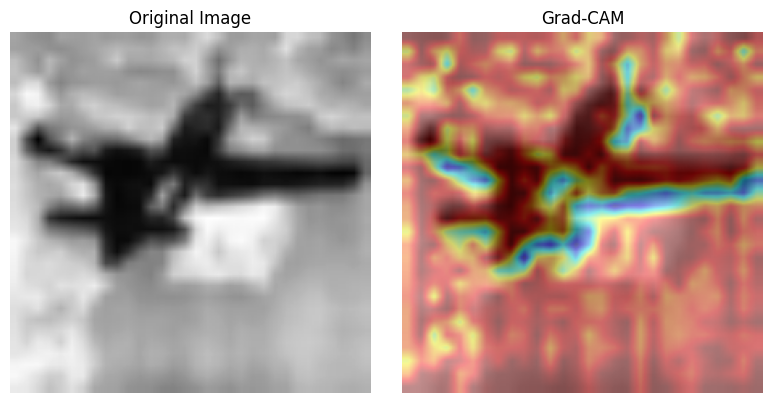

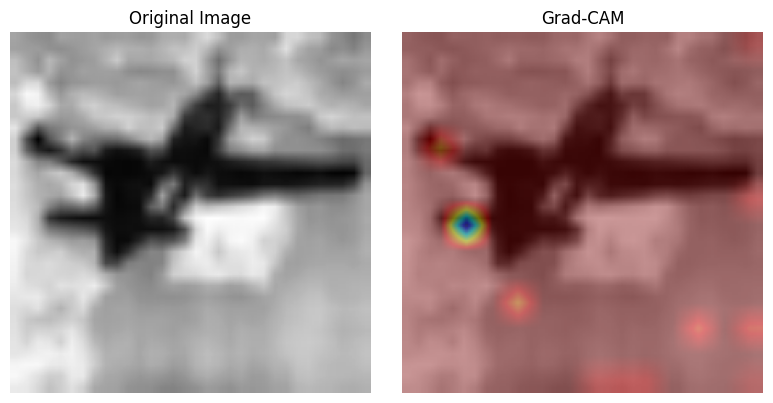

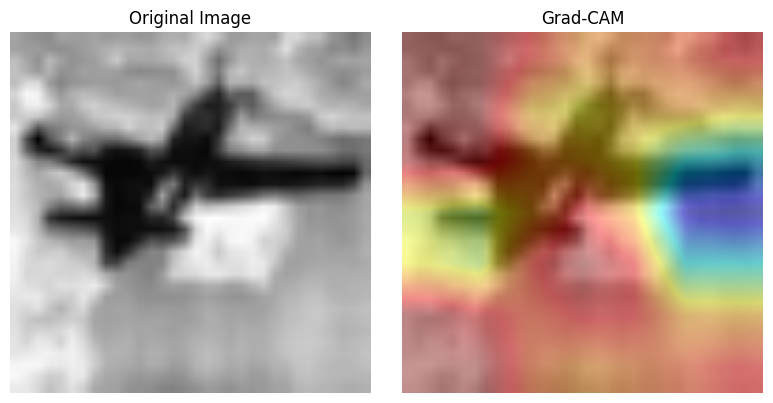

In [27]:
layers_to_check = [
    "layer2.0.conv1",
    "layer3.1.conv2",
    "layer4.1.conv2"  
]

for layer in layers_to_check:
    compute_gradcam(
        image=images[0].unsqueeze(0),
        activations=activations,
        gradients=gradients,
        target_layer_name=layer,
        index=0
    )
